In [2]:
import os
import sys
sys.path.append("..")

import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

from trace_analyzer import TraceAnalyzer

sim_result_root = "../sim_result"


In [3]:
class LayerAnalyzer():
    def __init__(self, trace_analyzer: TraceAnalyzer, layer: int, batch: int):
        # fetch subgraph
        graph = trace_analyzer.graph.get_graph()
        G = graph.subgraph(nodes=[n for n, nattr in graph.nodes(data=True)
            if nattr["layer"] == layer
            and nattr["batch"] == batch
            ])
        assert len(G.nodes) > 0
        self.G = G

        # record useful information about nodes
        wsrc = [n for n, attr in G.nodes(data=True) if attr["op_type"] == "wsrc"]
        assert len(wsrc) == 1
        insrc = [n for n, attr in G.nodes(data=True) if attr["op_type"] == "insrc"]
        assert len(insrc) == 1
        workers = [n for n, attr in G.nodes(data=True) if attr["op_type"] == "worker"]

        self.wsrc = wsrc[0]
        self.insrc = insrc[0]
        self.workers = workers
        worker = workers[0]  # a representative one

        self.w_cnt = int(G.nodes[self.wsrc]["cnt"])
        self.in_cnt = int(G.nodes[self.insrc]["cnt"])
        self.worker_cnt = int(G.nodes[worker]["cnt"])

        self.w_delay = int(G.nodes[self.wsrc]['delay'])
        self.in_delay = int(G.nodes[self.insrc]['delay'])
        self.worker_delay = int(G.nodes[worker]['delay'])

    def get_tile_latency(self):
        G = self.G
        wsrc = self.wsrc
        insrc = self.insrc
        w_cnt = self.w_cnt
        in_cnt = self.in_cnt
        workers = self.workers

        w_start = [float("inf")] * w_cnt
        w_end = [-float("inf")] * w_cnt
        in_start = [float("inf")] * in_cnt
        in_end = [-float("inf")] * in_cnt

        for w in workers:
            w_edges = G.edges[wsrc, w]["pkt"]
            w_pids = sorted(list(w_edges.keys()))

            in_edges = G.edges[insrc, w]["pkt"]
            in_pids = sorted(list(in_edges.keys()))

            for t in range(w_cnt):
                w_pkt = w_edges[w_pids[t]]
                w_start[t] = min(w_start[t], w_pkt["start_cycle"])
                w_end[t] = max(w_end[t], w_pkt["end_cycle"])

            for t in range(in_cnt):
                in_pkt = in_edges[in_pids[t]]
                in_start[t] = min(in_start[t], in_pkt["start_cycle"])
                in_end[t] = max(in_end[t], in_pkt["end_cycle"])

        # align different cnts
        if w_cnt > in_cnt:
            ratio = w_cnt // in_cnt
            w_latency = {i: l[1]-l[0] for i, l in enumerate(zip(w_start, w_end))}
            in_latency = {ratio*i: l[1]-l[0] for i, l in enumerate(zip(in_start, in_end))}
        elif w_cnt < in_cnt:
            ratio = in_cnt // w_cnt
            w_latency = {ratio*i: l[1]-l[0] for i, l in enumerate(zip(w_start, w_end))}
            in_latency = {i: l[1]-l[0] for i, l in enumerate(zip(in_start, in_end))}
        else:
            w_latency = {i: l[1]-l[0] for i, l in enumerate(zip(w_start, w_end))}
            in_latency = {i: l[1]-l[0] for i, l in enumerate(zip(in_start, in_end))}

        return w_latency, in_latency

    
    def get_slope(self):
        w_latency, in_latency = self.get_tile_latency()
        w_x = np.array(list(w_latency.keys()))
        w_y = np.array(list(w_latency.values()))
        in_x = np.array(list(in_latency.keys()))
        in_y = np.array(list(in_latency.values()))
        
        if len(w_x) > 2:
            w_lin = stats.linregress(w_x[1:], w_y[1:]).slope
        else:
            w_lin = 0
        if len(in_x) > 2:
            in_lin = stats.linregress(in_x[1:], in_y[1:]).slope
        else:
            in_lin = 0

        return w_lin, in_lin

    def get_intercept(self):
        w_latency, in_latency = self.get_tile_latency()
        w_x = np.array(list(w_latency.keys()))
        w_y = np.array(list(w_latency.values()))
        in_x = np.array(list(in_latency.keys()))
        in_y = np.array(list(in_latency.values()))
        
        if len(w_x) > 2:
            w_lin = stats.linregress(w_x[1:], w_y[1:]).intercept
        else:
            w_lin = 0
        if len(in_x) > 2:
            in_lin = stats.linregress(in_x[1:], in_y[1:]).intercept
        else:
            in_lin = 0

        return w_lin, in_lin

    
    def get_throughput(self):
        w_lin, in_lin = self.get_slope()
        w_throuput = 1 / (max(w_lin, 0) + self.w_delay)
        in_throughput = 1 / (max(in_lin, 0) + self.in_delay)
        return w_throuput, in_throughput

    
    def get_delay(self):
        return {
            "wsrc": self.w_delay,
            "insrc": self.in_delay,
            "worker": self.worker_delay,
        }

    def get_cnt(self):
        return {
            "wsrc": self.w_cnt,
            "insrc": self.in_cnt,
            "worker": self.worker_cnt,
        }

In [4]:
# check cnt ratio
ratio = dict()

for root, dirs, files in os.walk(sim_result_root):
    if len(files) < 4:
        continue  # no out.log

    taskname = os.path.split(root)[1]
    print(taskname)
    try:
        trace_analyzer = TraceAnalyzer(taskname)
    except KeyError:
        continue

    
    for layer in sorted(trace_analyzer.get_layers()):
        layer_analyzer = LayerAnalyzer(trace_analyzer, layer, 0)
        cnt = layer_analyzer.get_cnt()
        min_cnt = min(list(cnt.values()))
        for k, v in cnt.items():
            cnt[k] = cnt[k] / min_cnt

        s = f"{cnt['wsrc']}_{cnt['insrc']}_{cnt['worker']}"
        if s not in ratio.keys():
            ratio[s] = 0
        ratio[s] += 1

print(ratio)

{}


In [7]:
# plot theoretical throughput vs. injection rate
throughputs = []
injection_rates = []

for root, dirs, files in os.walk(sim_result_root):
    if len(files) < 4:
        continue  # no out.log

    taskname = os.path.split(root)[1]
    print(taskname)
    try:
        trace_analyzer = TraceAnalyzer(taskname)
    except KeyError:
        continue

    
    for layer in sorted(trace_analyzer.get_layers()):
        layer_analyzer = LayerAnalyzer(trace_analyzer, layer, 0)
        w_delay, in_delay = layer_analyzer.w_delay, layer_analyzer.in_delay
        w_slope, in_slope = layer_analyzer.get_slope()

        if w_slope > 0:
            injection_rates.append(1/w_delay)
            throughputs.append(1/(w_slope + w_delay))
        if in_slope > 0:
            injection_rates.append(1/in_delay)
            throughputs.append(1/(in_slope + in_delay))


bert_6_b1w1024_8x8
bert_4_b1w1024_8x8
inception_8_b1w1024_8x8
resnext50_32x4d_4_b1w1024_8x8
mobilenet_v3_small_6_b1w1024_8x8
ssd_r34_8_b1w1024_8x8
mobilenet_v3_small_4_b1w1024_8x8
inception_10_b1w1024_8x8
vgg16_6_b1w1024_8x8
bert-large_8_b1w1024_8x8
vgg16_2_b1w1024_8x8
resnet50_6_b1w1024_8x8
ssd_r34_4_b1w1024_8x8
mobilenet_v3_large_8_b1w1024_8x8
inception_6_b1w1024_8x8
unet_6_b1w1024_8x8
ssd_r34_6_b1w1024_8x8
unet_4_b1w1024_8x8
mobilenet_v3_small_8_b1w1024_8x8
alexnet_6_b1w1024_8x8
mnasnet_8_b1w1024_8x8
resnext50_32x4d_10_b1w1024_8x8
vgg16_4_b1w1024_8x8
bert-large_4_b1w1024_8x8
vgg16_8_b1w1024_8x8
wide_resnet50_2_6_b1w1024_8x8
mnasnet_10_b1w1024_8x8
resnet50_4_b1w1024_8x8
inception_4_b1w1024_8x8
resnet50_10_b1w1024_8x8
wide_resnet50_2_8_b1w1024_8x8
alexnet_4_b1w1024_8x8
alexnet_8_b1w1024_8x8
flappybird_4_b1w1024_8x8
unet_2_b1w1024_8x8
flappybird_2_b1w1024_8x8
mnasnet_4_b1w1024_8x8
bert-large_10_b1w1024_8x8
flappybird_8_b1w1024_8x8
bert_10_b1w1024_8x8
resnext50_32x4d_6_b1w1024_8x8
alexn

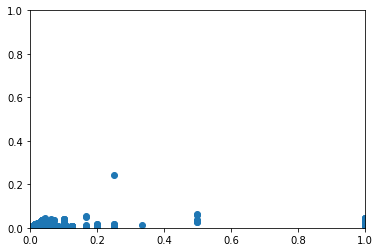

In [8]:
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.scatter(injection_rates, throughputs)

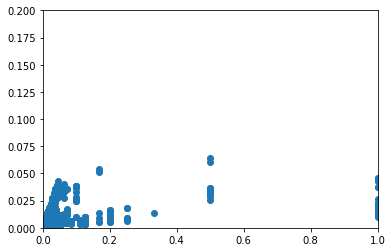

In [9]:
plt.xlim(0, 1)
plt.ylim(0, 0.2)
plt.scatter(injection_rates, throughputs)

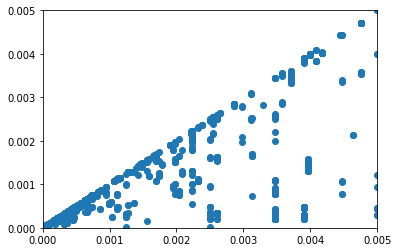

In [18]:
plt.xlim(0, 0.005)
plt.ylim(0, 0.005)
plt.scatter(injection_rates, throughputs)

In [ ]:
# dump slope figures
figure_root = "../figure"
if not os.path.exists(figure_root):
    os.mkdir(figure_root)
if not os.path.exists(os.path.join(figure_root, "small")):
    os.mkdir(os.path.join(figure_root, "small"))  # congestion < 1
if not os.path.exists(os.path.join(figure_root, "medium")):
    os.mkdir(os.path.join(figure_root, "medium")) # congestion 1 ~ 10
if not os.path.exists(os.path.join(figure_root, "large")):
    os.mkdir(os.path.join(figure_root, "large"))  # congestion > 10

def get_category(x):
    return "small" if x < 1 else (
        "medium" if x < 10 else "large"
    )

is_dumping = True

for root, dirs, files in os.walk(sim_result_root):
    if len(files) < 4:
        continue  # no out.log

    taskname = os.path.split(root)[1]
    print(taskname)
    try:
        trace_analyzer = TraceAnalyzer(taskname)
    except KeyError:
        continue

    for layer in sorted(trace_analyzer.get_layers()):
        layer_analyzer = LayerAnalyzer(trace_analyzer, layer, 0)

        w_latency, in_latency = layer_analyzer.get_tile_latency()
        w_x = np.array(list(w_latency.keys()))
        w_y = np.array(list(w_latency.values()))
        in_x = np.array(list(in_latency.keys()))
        in_y = np.array(list(in_latency.values()))
        
        delay = layer_analyzer.get_delay()
        cnt = layer_analyzer.get_cnt()
        w_slope, in_slope = layer_analyzer.get_slope()
        w_intercept, in_intercept = layer_analyzer.get_intercept()

        workload = min(list(delay.values()))
        congestion = max(w_slope, in_slope)/workload

        title = ""
        title += f"{layer}\n"
        title += f"wsrc cnt: {cnt['wsrc']}; insrc cnt: {cnt['insrc']}; worker cnt: {cnt['worker']}\n"
        title += f"wsrc delay: {delay['wsrc']}; insrc delay: {delay['insrc']}; worker delay: {delay['worker']}\n"
        title += f"congestion ratio = {congestion}"
        if not is_dumping:
            print(title)
        else:
            plt.title(title)

        plt.plot(w_x, w_y, label="wsrc")
        plt.plot(in_x, in_y, label="insrc")
        plt.plot(w_x, w_x * w_slope + w_intercept, label="wsrc_regress")
        plt.plot(in_x, in_x * in_slope + in_intercept, label="insrc_regress")
        plt.legend(loc="lower right")

        if is_dumping:
            category = get_category(congestion)
            plt.savefig(os.path.join(figure_root, category, f"{taskname}_{layer}.jpg"))
            plt.clf()
        else:
            plt.show()